# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict
import itertools
import operator
from tqdm import tqdm

## I. N-Gram Language Modeling

#### Utilities

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [3]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [4]:
datasets, vocab = load_wikitext()

# delta = 0.0005
# for n in [2, 3, 4]:
#     lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm.estimate(datasets['train'])

#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175


In [ ]:
type(vocab)

In [ ]:
vocab[:10]

In [ ]:
'<unk>' in vocab

### I.1 Interpolation

In [ ]:
class NGramInterpolation(object):
    pass

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

## II. Neural Language Modeling with a Recurrent Neural Network

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, RandomSampler, SequentialSampler,DataLoader
import matplotlib.pyplot as plt

### Utilities

In [6]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>') # validation token is not seen in the training dataset
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [9]:
train_dict=Dictionary(datasets) # excluding validation dataset #109
#all_dict=Dictionary(datasets, include_valid = True)

# example
rand_int = np.random.randint(1, len(datasets['valid']))
print(' '.join(datasets['valid'][rand_int]))
encoded = train_dict.encode_token_seq(datasets['valid'][rand_int])
print(f'\n encoded - {encoded}')
decoded = train_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

# checking
print('length of train_dict is ', len(train_dict)) # that's because <unk> is already in the dataset 
print('unique words in training dataset is ', len(vocab))

100%|██████████| 78274/78274 [03:09<00:00, 412.12it/s]

By 7 September , most of <unk> 's troops had started marching from <

 encoded - [830, 2280, 753, 10, 402, 5, 3, 115, 1225, 510, 1360, 7393, 107, 361]

 decoded - ['By', '7', 'September', ',', 'most', 'of', '<unk>', "'s", 'troops', 'had', 'started', 'marching', 'from', '<']
length of train_dict is  33178
unique words in training dataset is  33175


In [17]:
# given the dictionary from above, now write a function that tokenize the all datasets into id's
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

# Given a tokenzied dataset with ngram defined, slice the input sequences into n-grams 
# [0,1,2,3,4,5], 2 -> [0,1], [1,2], [2,3], [3,4], [4,5]
def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=2):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

# # Now we create a dataset
class NgramDataset(Dataset):
    def __init__(self, sliced_dataset_split):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.tensor(i, dtype=torch.long) for i in sliced_dataset_split]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)

def batchify(list_minibatch):
    inp_list = [i[:-1] for i in list_minibatch]
    tar_list = [i[-1] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=0) # list of tensors and create a new tensor a u-dimension specified by dim
    tar_tensor = torch.stack(tar_list, dim=0)
    # cat: take a list of tensors and use existing dimension to concatent. Cannot create a new u-dimension speicfied. 

    return inp_tensor, tar_tensor

In [11]:
#  returns dictionary of three items with 'train', 'valid' and 'test' with lists of token ids 
tokenized_ngram = tokenize_dataset(datasets, train_dict, ngram_order=2)

# returns dictionary of three and lists of sliced n-grams
sliced_ngram = slice_sequences_given_order(tokenized_ngram, ngram_order=2)

# check that the sentence is encoded with (n-1)<bos> and can be decoded back to tokens 
decoded_with_spec = train_dict.decode_idx_seq(tokenized_ngram['train'][3010])
print(f'\n decoded with spec - {decoded_with_spec}')

ngram_datasets = {}
ngram_loaders = {}
for split, dataset_sliced in sliced_ngram.items():
    if split == 'train':
        shuffle_ = True
    else:
        shuffle_ = False
    dataset_ = NgramDataset(dataset_sliced)
    ngram_datasets[split] = dataset_
    ngram_loaders[split] = DataLoader(dataset_, batch_size=2048, shuffle=shuffle_, collate_fn=batchify)

100%|██████████| 9708/9708 [00:00<00:00, 23711.95it/s]



 decoded with spec - ['<bos>', 'The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.', '<eos>']


In [12]:
print('The length of original training dataset is: ', len(datasets['train']))
print('The length of tokenzied training dataset is: ', len(tokenized_ngram['train']))
print('Slided_ngram for training dataset now has length of ', len(sliced_ngram['train']))

The length of original training dataset is:  78274
The length of tokenzied training dataset is:  78274
Slided_ngram for training dataset now has length of  2003028


In [13]:
print(tokenized_ngram['valid'][10])
print(train_dict.decode_idx_seq(tokenized_ngram['valid'][10]))

[0, 504, 1506, 7106, 741, 459, 20, 140, 98, 432, 19366, 10, 150, 15605, 13, 260, 3748, 955, 1826, 1384, 1145, 98, 1722, 4303, 39, 1]
['<bos>', 'This', 'may', 'occur', 'several', 'times', 'a', 'year', 'for', 'young', 'lobsters', ',', 'but', 'decreases', 'to', 'once', 'every', '1', '–', '2', 'years', 'for', 'larger', 'animals', '.', '<eos>']


In [14]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])
    
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor



In [15]:
tensor_dataset = {}

for split, listoflists in tokenized_ngram.items():
    tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
tensor_dataset['train'][24]

(tensor([[  0, 282,  13, 283, 181, 194, 195, 284,  13,  20, 285, 286,  39]]),
 tensor([[282,  13, 283, 181, 194, 195, 284,  13,  20, 285, 286,  39,   1]]))

In [16]:
loaders = {}
batch_size = 32
for split, dataset in tensor_dataset.items():
    loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

### Baseline Model: RNN

In [20]:
from torch.nn import RNNBase, RNN
from torch.nn import Embedding
from torch.nn import Linear, functional
import torch.optim as optim

In [ ]:
# example embedding layer
lookup = Embedding(num_embeddings=len(train_dict), embedding_dim=64, padding_idx=train_dict.get_id('<pad>'))
lookup.weight.size()
# train_dict = vocab size + 4

In [ ]:
# Example input
input_ = train_dict.encode_token_seq('hello world'.split(' '))
print(f'discrete input: {[input_]}')

input_continious = lookup(torch.tensor([input_], dtype=torch.long))
print(f'continious input size: {input_continious.size()}')

In [ ]:
lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
# before nn.RNN is hidden
# Now: you do lookup table, and returns the tensors of sequence. No need of concat, becuase RNN naturally takes care of this
# RNN natrually takes multi sentence inputs and outputs hidden_size 
rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
projection = nn.Linear(options['hidden_size'], options['num_embeddings'])

In [ ]:
lookup

In [ ]:
rnn

In [ ]:
projection

In [ ]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        # before nn.RNN is hidden
        # Now: you do lookup table, and returns the tensors of sequence. No need of concat, becuase RNN naturally takes care of this
        # RNN natrually takes multi sentence inputs and outputs hidden_size 
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        # project of outputs 
        # rnn_outputs: tupple with second element being last hidden state. 
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [ ]:
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128 # output of dimension 
    num_layers = 2
    rnn_dropout = 0.1
    input_size = lookup.weight.size(1)
    vocab_size = lookup.weight.size(0)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    
    model = RNNLanguageModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)



In [ ]:
# check model
model

In [ ]:
plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

In [ ]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of RNN baseline model')
plt.show()

### II.1 LSTM and Hyper-Parameters

In [18]:
from torch.nn import LSTM
# input_size, hidden_size, num_layers. 
# Optional: bias = False, dropout = 0 (probability of dropout)
# bidirectional = False. 
rnn = nn.LSTM(10, 20, 2)

# input: tensor containing feature of the input sequence 
# shape: seq_len, batch, input_size
input = torch.randn(5,3,10)

#h0: tensor contain hidden state for t = seq_len
# shape: num_layers * num*directions, batch, hidden_size
h0 = torch.randn(2,3,20)

#c0: tensor contain cell state for t = seq_length
# shape: num_layers * num_directions, batch, hidden_size 
c0 = torch.randn(2,3,20)

# output: shape (seq_len, batch, num_direction * hidden size)
output, (hn,cn) = rnn(input, (h0,c0))

In [21]:
# example embedding layer
lookup = Embedding(num_embeddings=len(train_dict), embedding_dim=64, padding_idx=train_dict.get_id('<pad>'))
lookup.weight.size()
# train_dict = vocab size + 3

torch.Size([33178, 64])

In [22]:
# From the baseline, we will stop the epoch around 20 
class LSTMModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], 
                            dropout=options['lstm_dropout'], batch_first=True, bias = options['bias'],
                           bidirectional = options['bid'])
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        # project of outputs 
        # rnn_outputs: tupple with second element being last hidden state. 
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [31]:
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = LSTMModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128 # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
#     input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    
    model = LSTMModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [32]:
#model = LSTMModel(options).to(current_device)
plot_cache = []
min_val_loss = 20 
for epoch_number in range(20):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_LSTM.pt')
            print('Saving best model at epoch', epoch_number)
            
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

Step 0 avg train loss = 10.4141
Step 100 avg train loss = 7.8508
Step 200 avg train loss = 7.1631
Step 300 avg train loss = 7.0615
Step 400 avg train loss = 6.9351
Step 500 avg train loss = 6.8432
Step 600 avg train loss = 6.7137
Step 700 avg train loss = 6.6335
Step 800 avg train loss = 6.5849
Step 900 avg train loss = 6.4968
Step 1000 avg train loss = 6.4613
Step 1100 avg train loss = 6.4289
Step 1200 avg train loss = 6.3595
Step 1300 avg train loss = 6.3364
Step 1400 avg train loss = 6.2780
Step 1500 avg train loss = 6.2327
Step 1600 avg train loss = 6.2201
Step 1700 avg train loss = 6.2095
Step 1800 avg train loss = 6.1694
Step 1900 avg train loss = 6.1184
Step 2000 avg train loss = 6.1127
Step 2100 avg train loss = 6.0936
Step 2200 avg train loss = 6.0831
Step 2300 avg train loss = 6.0651
Step 2400 avg train loss = 6.0419
Validation loss after 0 epoch = 5.8386
Saving best model at epoch 0
Step 0 avg train loss = 5.9000
Step 100 avg train loss = 5.9375
Step 200 avg train loss = 5.9

Step 300 avg train loss = 4.6730
Step 400 avg train loss = 4.6779
Step 500 avg train loss = 4.7050
Step 600 avg train loss = 4.6557
Step 700 avg train loss = 4.6833
Step 800 avg train loss = 4.6821
Step 900 avg train loss = 4.6994
Step 1000 avg train loss = 4.6950
Step 1100 avg train loss = 4.7171
Step 1200 avg train loss = 4.7176
Step 1300 avg train loss = 4.7203
Step 1400 avg train loss = 4.6990
Step 1500 avg train loss = 4.7214
Step 1600 avg train loss = 4.7206
Step 1700 avg train loss = 4.7008
Step 1800 avg train loss = 4.7088
Step 1900 avg train loss = 4.7180
Step 2000 avg train loss = 4.7178
Step 2100 avg train loss = 4.7240
Step 2200 avg train loss = 4.7160
Step 2300 avg train loss = 4.7438
Step 2400 avg train loss = 4.7261
Validation loss after 9 epoch = 5.3046
Step 0 avg train loss = 4.6095
Step 100 avg train loss = 4.6183
Step 200 avg train loss = 4.5834
Step 300 avg train loss = 4.6130
Step 400 avg train loss = 4.6545
Step 500 avg train loss = 4.6085
Step 600 avg train loss 

Step 1200 avg train loss = 4.3361
Step 1300 avg train loss = 4.3317
Step 1400 avg train loss = 4.3505
Step 1500 avg train loss = 4.3344
Step 1600 avg train loss = 4.3457
Step 1700 avg train loss = 4.3524
Step 1800 avg train loss = 4.3406
Step 1900 avg train loss = 4.3630
Step 2000 avg train loss = 4.3765
Step 2100 avg train loss = 4.3786
Step 2200 avg train loss = 4.3522
Step 2300 avg train loss = 4.3823
Step 2400 avg train loss = 4.3586
Validation loss after 18 epoch = 5.4734
Step 0 avg train loss = 4.0202
Step 100 avg train loss = 4.2330
Step 200 avg train loss = 4.2752
Step 300 avg train loss = 4.2600
Step 400 avg train loss = 4.2579
Step 500 avg train loss = 4.2462
Step 600 avg train loss = 4.2940
Step 700 avg train loss = 4.2749
Step 800 avg train loss = 4.2864
Step 900 avg train loss = 4.2805
Step 1000 avg train loss = 4.2625
Step 1100 avg train loss = 4.3175
Step 1200 avg train loss = 4.2914
Step 1300 avg train loss = 4.2962
Step 1400 avg train loss = 4.3077
Step 1500 avg train 

In [36]:
plot_cache

[]

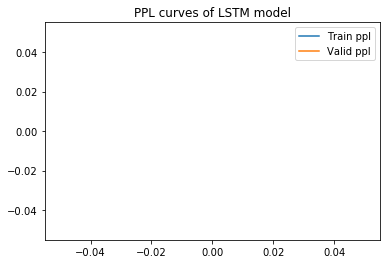

In [35]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of LSTM model')
plt.show()

In [38]:
2**(5.2811/np.log(2))

196.58600106203332

In [ ]:
perp = np.array(2**(i[1]/np.log(2)) for i in plot_cache)
# or 
print('The minimum validation loss occurred at {} and it is'.formate(perp.index(min(perp)),min(perp)))
perp.index(min(perp))

In [ ]:
min(2**(i[1]/np.log(2)) for i in plot_cache)
np.argmin(perp)

#### Results (LSTM vs. Baseline)

#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [40]:
# parameters:
options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }
model = LSTMModel(options)
model.load_state_dict(torch.load('best_LSTM.pt'))
model.eval()



LSTMModel(
  (lookup): Embedding(33178, 64, padding_idx=2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)

In [41]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy()) 
    # transfer tensor back to cpu
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### II.2.1 Word Similarity

In [109]:
def cos_similarity(weight_matrix, words):
#make sure at least appear in the text once 
    whole_word = list()
    for word in words:
        if word not in vocab:
            raise NotImplementedError("selected token must appeared in the corpus once, please replace {}".format(word))
            
    # define my cosine similarity. each input is 1 x 64. Therefore evaluate along x'axis returns a scalar 
    cos = nn.CosineSimilarity(dim = 0, eps = 1e-6)

    dis_list = defaultdict(lambda: defaultdict(float))

    for w in words:
        wid = train_dict.get_id(w)
        temp_list = list()
        for i in range(len(weight_matrix)):
            if i == wid:
                continue
            else: 
                dis = cos(weight_matrix[wid], weight_matrix[i])
                temp_list.append(tuple((train_dict.get_token(i), dis.item())))
        temp_list = sorted(temp_list, key = lambda x: x[-1])
        dis_list[w]['worst'] = temp_list[:10]
        dis_list[w]['best'] = temp_list[-10:]
        worst_words = [x[0] for x in temp_list[:10]]
        best_words = [x[0] for x in temp_list[-10:]]
        whole_word += worst_words + best_words
    return dis_list, whole_word + words

#### II.2.2 Embedding Layer

In [110]:
weight_matrix_lkup = model.lookup.weight
words = ['productive', 'teenage','south','antelope','smart']
# some verbs, and nouns
proj_list, whole_words = cos_similarity(weight_matrix_proj, words)

In [112]:
proj_list['south']['best']

[('Sognsvann', 0.41883814334869385),
 ('Hero', 0.4204072058200836),
 ('head', 0.4278274476528168),
 ('Hansen', 0.4294733703136444),
 ('Sundays', 0.4346746504306793),
 ('Kowang', 0.44530779123306274),
 ('Surf', 0.45279738306999207),
 ('quarter', 0.46572181582450867),
 ('Jammer', 0.47306203842163086),
 ('Player', 0.5170460343360901)]

In [113]:
proj_list['south']['worst']

[('asks', -0.4493196904659271),
 ('Feeling', -0.4384562373161316),
 ('Describing', -0.43770161271095276),
 ('We', -0.43556010723114014),
 ('Jonas', -0.43024149537086487),
 ('Integrated', -0.4137445092201233),
 ('Marvin', -0.41330817341804504),
 ('gateway', -0.4120998680591583),
 ('undecided', -0.409074991941452),
 ('Gillian', -0.4073803722858429)]

/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/myenv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


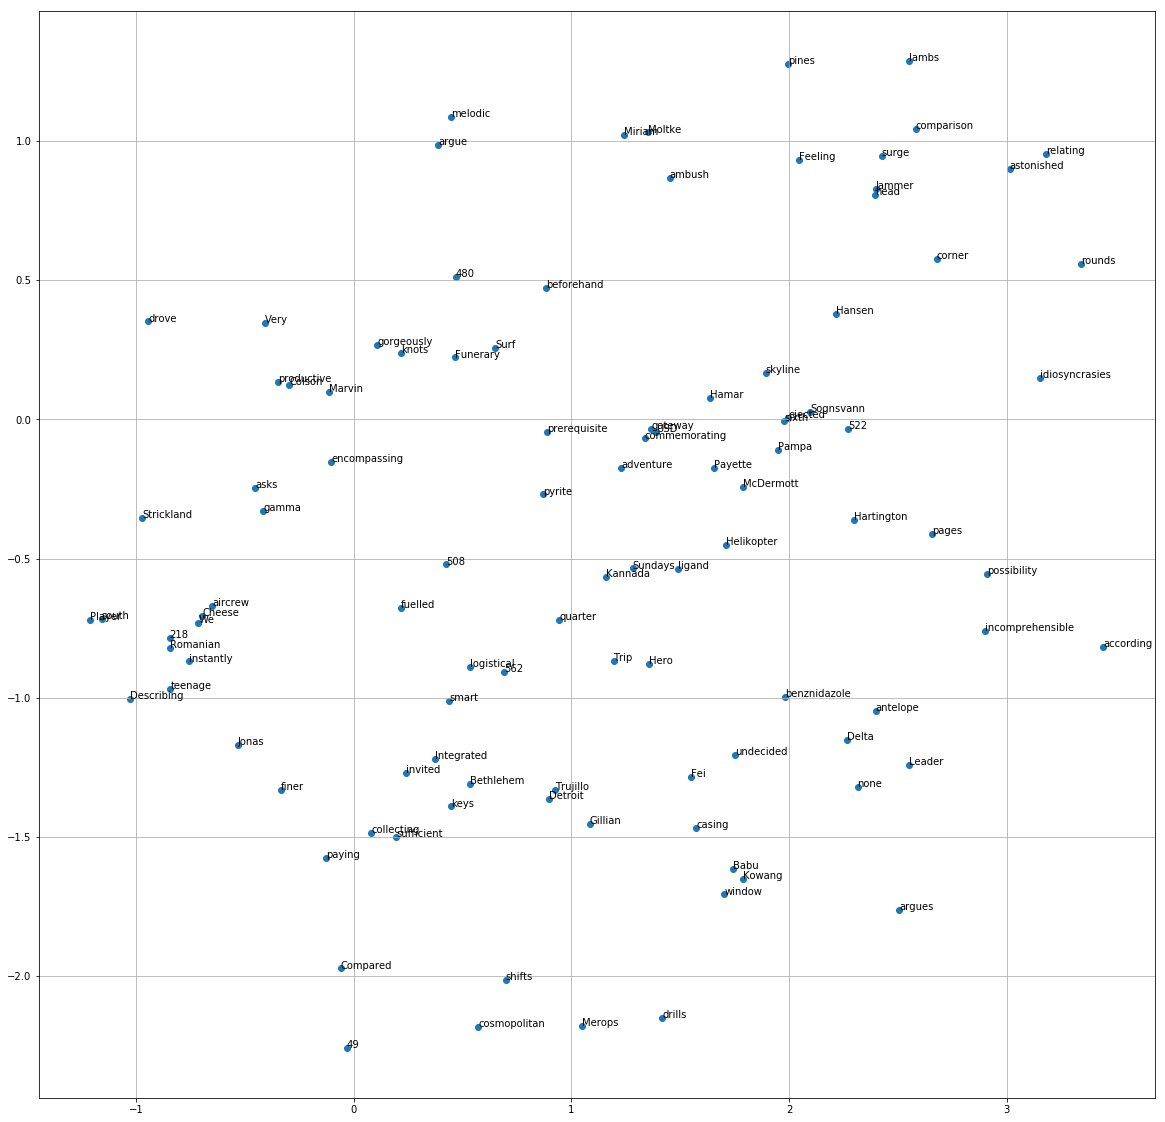

In [111]:
whole_word_ids = train_dict.encode_token_seq(whole_words)   # e.g. use dictionary.get_id on a list of words

umap_plot(weight_matrix_lkup, whole_word_ids, whole_words)

#### II.2.3 Projection Layer

In [115]:
weight_matrix_proj = model.projection.weight
words = ['productive', 'teenage','south','antelope','smart']
# some verbs, and nouns
proj_list, whole_words = cos_similarity(weight_matrix_proj, words)

/home/sl7085/.conda/envs/myenv/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/myenv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


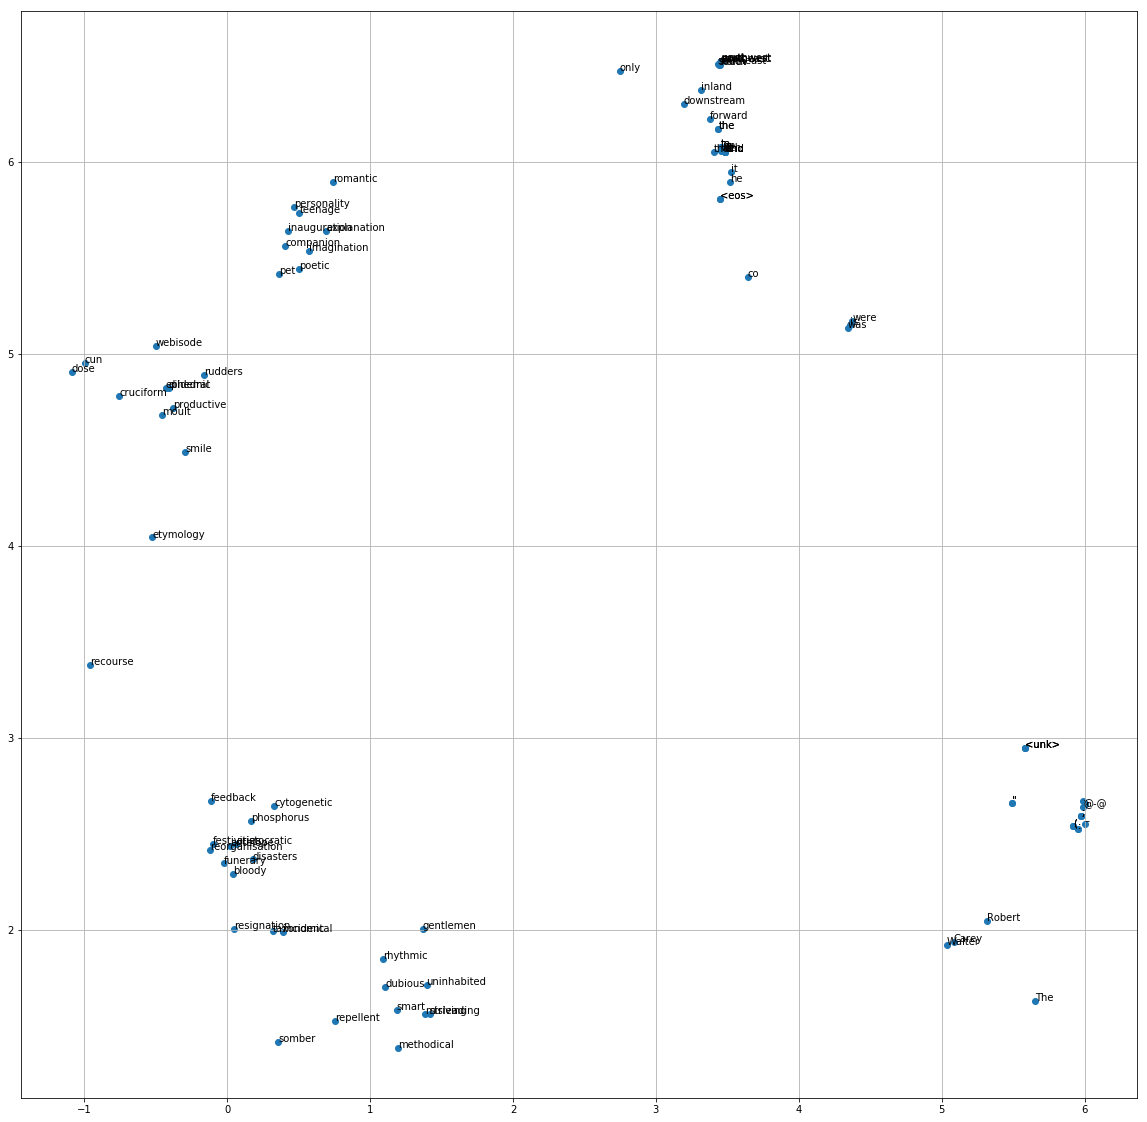

In [116]:
whole_word_ids = train_dict.encode_token_seq(whole_words)   # e.g. use dictionary.get_id on a list of words
umap_plot(weight_matrix_proj, whole_word_ids, whole_words)

### II.3 Scoring

#### II.3.2 Highest and Lowest scoring sequences

#### II.3.3 Modified sequences

### II.4 Sampling

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples